In [1]:
#load necessary packages and data files
Packages <- c("dplyr", "ggplot2","stringr","fields", "tidyr",  "lubridate", "RColorBrewer", "igraph", "lubridate")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/parentage/')

#download.file(url = "https://raw.githubusercontent.com/pinskylab/genomics/master/data/known_issues.csv", destfile = "~/parentage/r_data/known_issues.csv")
issues <- read.csv("~/parentage/r_data/known_issues.csv", header=T, stringsAsFactors = F)
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/fish_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/fish_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/anem_db.RData?raw=true", destfile = "~/parentage/r_data/anem_db.RData")
load("~/parentage/r_data/anem_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/dives_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/dives_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/fish_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/fish_db.RData")
load("~/parentage/r_data/gps_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/anems_tagged.RData", destfile = "~/parentage/r_data/anems_tagged.RData")
load("~/parentage/r_data/anems_tagged.RData")
#download.file(url = "https://github.com/pinskylab/genomics/blob/master/data/fish-obs.RData?raw=true", destfile = "~/parentage/r_data/fish-obs.RData")
fish_obs <- readRDS("~/parentage/r_data/fish-obs.RData") 
#download.file(url = "https://raw.githubusercontent.com/pinskylab/db_backups/master/ligation_1-7-20.csv", destfile = "~/parentage/r_data/ligation_db.csv")
lig_db <- read.csv("~/parentage/r_data/ligation_db.csv", header=T, stringsAsFactors = F)
#download.file(url = "https://raw.githubusercontent.com/pinskylab/db_backups/master/digest_1-7-20.csv", destfile = "~/parentage/r_data/digest_db.csv")
dig_db <- read.csv("~/parentage/r_data/digest_db.csv", header=T, stringsAsFactors = F)
#download.file(url = "https://raw.githubusercontent.com/pinskylab/db_backups/master/extraction_1-7-20.csv", destfile = "~/parentage/r_data/extraction_db.csv")
ext_db <- read.csv("~/parentage/r_data/extraction_db.csv", header=T, stringsAsFactors = F)
offs_input <- read.table(file="~/parentage/colony2/20190523_1340loci/input/all_offspring_corrected.txt", sep= " ", header=TRUE) %>%
    mutate(fish_indiv=as.character(fish_indiv))

"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0




In [85]:
#load sibling results

#sibs18 <- read.csv(file= "/local/home/katrinac/Sibling-Dispersal/data/1340loci_2018.FullSibDyad.txt", header= TRUE, stringsAsFactors = F) %>%
#    mutate(year="2018")
#do the above line of code for every year of analysis

#allsibs <- bind_rows(sibs12, sibs13, sibs14, sibs15, sibs16, sibs17, sibs18) %>%
#    filter(Probability >= 0.95)

#write.csv(allsibs, file= "/local/home/katrinac/Sibling-Dispersal/data/AllYearsFullSibs.csv", row.names=FALSE)
siblings <- read.csv(file= "/local/home/katrinac/Sibling-Dispersal/data/AllYearsFullSibs.csv", header= TRUE, stringsAsFactors = F)  
nrow(siblings) #should be 124

[1] 124

In [43]:
str(siblings)

'data.frame':	132 obs. of  4 variables:
 $ OffspringID1: chr  "L0340" "L0340" "L0340" "L0340" ...
 $ OffspringID2: chr  "L0341" "L0373" "L1215" "L2571" ...
 $ Probability : num  1 0.913 1 0.999 1 1 0.997 0.989 0.998 0.974 ...
 $ year        : int  2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 ...


In [47]:

#add meta data
#from Allison, just putting all the meta data together (Constants_database_common_functions.R)
##### Match up other relevant info (site, date, fish_indiv, etc.) to fish in the clownfish table
# Pull out year and month into a separate column in dives_db
dives_db_processed <- dives_db %>%
  mutate(year = as.integer(substring(date,1,4))) %>%
  mutate(month = as.integer(substring(date,6,7))) %>%
  mutate(dive_date = date(date))

# Pull all APCL caught or otherwise in the clownfish table
allfish_fish <- fish_db %>%
  select(fish_table_id, anem_table_id, fish_spp, sample_id, anem_table_id, recap, tag_id, color, sex, size, fish_obs_time, fish_notes) %>%
  filter(fish_spp == 'APCL') %>%
  mutate(size = as.numeric(size))  # make the size numeric (rather than chr) so can do means and such

# and their corresponding anemones
allfish_anems <- anem_db %>%
  select(anem_table_id, dive_table_id, anem_obs, anem_id, old_anem_id, anem_notes, anem_obs_time) %>%
  filter(anem_table_id %in% allfish_fish$anem_table_id)

# and the corresponding dive info
allfish_dives <- dives_db_processed %>%
  select(dive_table_id, dive_type, date, year, month, site, gps, dive_notes) %>%
  filter(dive_table_id %in% allfish_anems$dive_table_id) 

# join together
allfish_caught <- left_join(allfish_fish, allfish_anems, by="anem_table_id")
allfish_caught <- left_join(allfish_caught, allfish_dives, by="dive_table_id")

# add in the gen_ids and fish_indiv (now in a separate gen_id table) - gen_id only comes in the time the fish was sequenced, not at all captures
allfish_caught <- left_join(allfish_caught, (fish_obs %>% select(fish_table_id, gen_id, fish_indiv)), by = "fish_table_id")

#get sample ids for ligation ids
ext_db <- ext_db %>%
    select(extraction_id, sample_id)
dig_db <- dig_db %>%
    select(extraction_id, digest_id)
lig_db <- lig_db %>%
    select(ligation_id, digest_id)
ext_dig <- left_join(ext_db, dig_db, by="extraction_id")
dig_lig <- left_join(ext_dig, lig_db, by="digest_id")
lig_samp <- dig_lig %>%
    select(ligation_id, sample_id) %>%
    filter(sample_id %in% allfish_caught$sample_id) #remove everything but sampled APCL

fish_meta <- left_join(allfish_caught, lig_samp,  by="sample_id") %>%
    select(fish_indiv, size, color, sex, gen_id, ligation_id, sample_id, site, date, anem_obs_time, gps) %>%
    filter(!is.na(fish_indiv)) %>%
    distinct(ligation_id, .keep_all = T) %>%
    mutate(ligation_year=year(date))

#write out fish meta data for Connor



In [37]:
#get specific metadata for offspring
sib_samp1 <- fish_meta %>%
    filter(ligation_id %in% siblings$OffspringID1) 
colnames(sib_samp1) <- paste("sib1", colnames(sib_samp1), sep = "_")

#get specific metadata for parents
sib_samp2 <- fish_meta %>%
    filter(ligation_id %in% siblings$OffspringID2) 
colnames(sib_samp2) <- paste("sib2", colnames(sib_samp2), sep = "_")

#join back into parentage match format
meta_with_sib1 <- left_join(sib_samp1, siblings, by=c(sib1_ligation_id="OffspringID1"))
    

full_sibs <- left_join(meta_with_sib1, sib_samp2,   by=c(OffspringID2="sib2_ligation_id")) 

#the long haul of adding lat lons
results_meta <- full_sibs %>%
    mutate(sib1_time_date =as.character(str_c(sib1_date, sib1_anem_obs_time, sep = " "))) %>%
    mutate(sib1_time_date = ymd_hms(sib1_time_date))%>%
    mutate(sib1_time_date = force_tz(sib1_time_date, tzone = "Asia/Manila")) %>%
    mutate(sib1_time_date = with_tz(sib1_time_date, tzone = "UTC")) %>%
    mutate(sib1_year = year(sib1_time_date)) %>%
    mutate(sib1_month = month(sib1_time_date)) %>%
    mutate(sib1_day = day(sib1_time_date)) %>%
    mutate(sib1_hour = hour(sib1_time_date)) %>%
    mutate(sib1_minute = minute(sib1_time_date)) %>%
    mutate(sib2_time_date =as.character(str_c(sib2_date, sib2_anem_obs_time, sep = " "))) %>%
    mutate(sib2_time_date = ymd_hms(sib2_time_date))%>%
    mutate(sib2_time_date = force_tz(sib2_time_date, tzone = "Asia/Manila")) %>%
    mutate(sib2_time_date = with_tz(sib2_time_date, tzone = "UTC")) %>%
    mutate(sib2_year = year(sib2_time_date)) %>%
    mutate(sib2_month = month(sib2_time_date)) %>%
    mutate(sib2_day = day(sib2_time_date)) %>%
    mutate(sib2_hour = hour(sib2_time_date)) %>%
    mutate(sib2_minute = minute(sib2_time_date))

gps <- gps_db %>%
    mutate(lat=as.numeric(lat)) %>%
    mutate(lon=as.numeric(lon)) %>%
    mutate(time_date = ymd_hms(time)) %>%
    mutate(year = year(time_date)) %>%
    mutate(month = month(time_date)) %>%
    mutate(day = day(time_date)) %>%
    mutate(hour = hour(time_date)) %>%
    mutate(minute = minute(time_date)) %>%
    select(-time_date, -elev, -time) %>%
    group_by(unit, year, month, day, hour, minute) %>%
    mutate(lat =mean(lat)) %>% #create within minute averages
    mutate(lon=mean(lon)) %>%
    distinct(.keep_all = T)

add_sib1_loc <- left_join(results_meta, gps, by=c(sib1_gps="unit",sib1_year="year", sib1_month="month", sib1_day="day", sib1_hour="hour", sib1_minute="minute")) %>%
    rename(sib1_lat="lat", sib1_lon="lon") 

sib_dist <- left_join(add_sib1_loc, gps, by=c(sib2_gps="unit",sib2_year="year", sib2_month="month", sib2_day="day", sib2_hour="hour", sib2_minute="minute")) %>%
    rename(sib2_lat="lat", sib2_lon="lon") 

In [35]:

#calculate the distance 
alldists <- rdist.earth(as.matrix(sib_dist[,c('sib1_lon', 'sib1_lat')]), as.matrix(sib_dist[,c('sib2_lon', 'sib2_lat')]), miles=FALSE, R=6371)
sib_dist$dist_km <- diag(alldists)



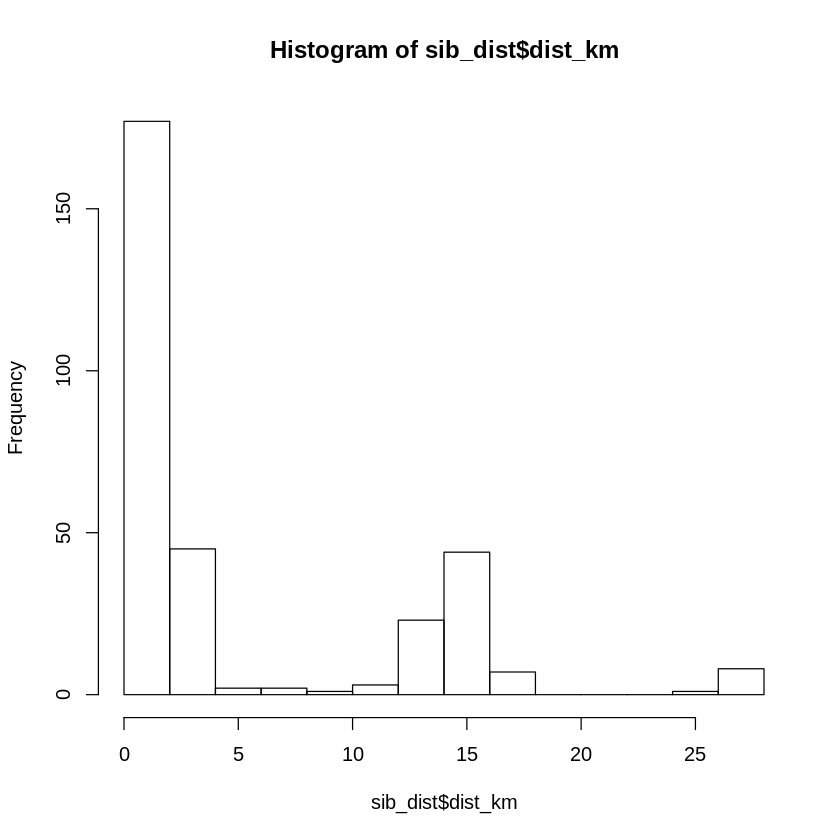

In [36]:
hist(sib_dist$dist_km) #looks like the dispersal results

In [84]:
#add lat/lons and distances between all individuals, save for Connor

results_meta <- fish_meta %>%
    mutate(time_date =as.character(str_c(date, anem_obs_time, sep = " "))) %>%
    mutate(time_date = ymd_hms(time_date))%>%
    mutate(time_date = force_tz(time_date, tzone = "Asia/Manila")) %>%
    mutate(time_date = with_tz(time_date, tzone = "UTC")) %>%
    mutate(year = year(time_date)) %>%
    mutate(month = month(time_date)) %>%
    mutate(day = day(time_date)) %>%
    mutate(hour = hour(time_date)) %>%
    mutate(minute=minute(time_date))

fish_meta <- left_join(results_meta, gps, by=c(gps="unit","year", "month", "day", "hour", "minute")) 

saveRDS(fish_meta, file="~/Sibling-Dispersal/data/fish_meta.rds")